# Analysis of ICSE Research Track Publications by Replicability & AI Use (2023 & 2024)

# Imports & Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import bigrams
        
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dave\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dave\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Dave\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [45]:
# All Papers
df_23 = pd.read_csv('results/bib/ICSE2023_papers.csv')
df_24 = pd.read_csv('results/bib/ICSE2024_papers.csv')

# Relevant LLM Papers
df_ai_23 = pd.read_csv('results/ai/AI_ICSE2023_papers.csv')
df_ai_24 = pd.read_csv('results/ai/AI_ICSE2024_papers.csv')

# Merge Relevant LLM papers with all papers
df_23 = df_23.merge(
    df_ai_23[["title", "reviewer", "relevant"]],
    on="title",
    how="left"
)
df_23["reviewer"] = df_23["reviewer"].fillna("N/A")
df_23["relevant"] = df_23["relevant"].fillna(False)

df_24 = df_24.merge(
    df_ai_24[["title", "reviewer", "relevant"]],
    on="title",
    how="left"
)
df_24["reviewer"] = df_24["reviewer"].fillna("N/A")
df_24["relevant"] = df_24["relevant"].fillna(False)

# Combine dataframes for all years
df_combined = pd.concat([df_23, df_24], ignore_index=True)

C:\Users\Dave\AppData\Local\Temp\ipykernel_1752\1620053528.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_23["relevant"] = df_23["relevant"].fillna(False)
C:\Users\Dave\AppData\Local\Temp\ipykernel_1752\1620053528.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_24["relevant"] = df_24["relevant"].fillna(False)


In [24]:
df_23.head()

,title,authors,url,abstract,artifact_available,artifact_reusable,artifact_functional,ai,reviewer,relevant
0,Log Parsing with Prompt-Based Few-Shot Learning,"Le, Van-Hoang, Zhang, Hongyu",https://doi.org/10.1109/ICSE48619.2023.00204,Logs generated by large-scale software systems...,False,False,False,True,DW,True
1,Context-Aware Bug Reproduction for Mobile Apps,"Huang, Yuchao, Wang, Junjie, Liu, Zhe, Wang, S...",https://doi.org/10.1109/ICSE48619.2023.00196,Bug reports are vital for software maintenance...,False,False,False,True,DW,True
2,Vulnerability Detection with Graph Simplificat...,"Wen, Xin-Cheng, Chen, Yupan, Gao, Cuiyun, Zhan...",https://doi.org/10.1109/ICSE48619.2023.00191,Prior studies have demonstrated the effectiven...,False,False,False,False,N/A,False
3,DIVER: Oracle-Guided SMT Solver Testing with U...,"Kim, Jongwook, So, Sunbeom, Oh, Hakjoo",https://doi.org/10.1109/ICSE48619.2023.00187,"We present DIVER, a novel technique for effect...",True,True,False,False,N/A,False
4,On the Robustness of Code Generation Technique...,"Mastropaolo, Antonio, Pascarella, Luca, Guglie...",https://doi.org/10.1109/ICSE48619.2023.00181,Software engineering research has always being...,False,False,False,False,N/A,False


# Overall Summary

In [25]:
def conference_overview(df, title):
    """
    Print a summary of the conference data.
    """
    print(title)
    print("------------------------")
    print(f"Total papers: {len(df)}\n")
    print(df["ai"].value_counts())
    print()
    print(f"Total Relevant LLM papers: {df['relevant'].sum()}\n")
    print(df["artifact_available"].value_counts())

    papers_with_artifacts = df[df["artifact_available"]]
    print(f"\nOf {len(papers_with_artifacts)} papers with available artifacts:")
    print(f"{papers_with_artifacts['artifact_reusable'].sum()} reusable artifacts")
    print(f"{papers_with_artifacts['artifact_functional'].sum()} functional artifacts\n\n")

In [26]:
conference_overview(df_23, "Overview for ICSE 2023")
conference_overview(df_24, "Overview for ICSE 2024")

Overview for ICSE 2023
------------------------
Total papers: 210

ai
False    159
True      51
Name: count, dtype: int64

Total Relevant LLM papers: 23

artifact_available
False    130
True      80
Name: count, dtype: int64

Of 80 papers with available artifacts:
51 reusable artifacts
13 functional artifacts


Overview for ICSE 2024
------------------------
Total papers: 236

ai
False    144
True      92
Name: count, dtype: int64

Total Relevant LLM papers: 54

artifact_available
False    157
True      79
Name: count, dtype: int64

Of 79 papers with available artifacts:
63 reusable artifacts
2 functional artifacts




In [50]:
# Calculate proportions in the combined dataset
total_relevant = df_combined['relevant'].sum()
total_non_relevant = (~df_combined['relevant']).sum()

relevant_with_artifact = df_combined[(df_combined['relevant']) & (df_combined['artifact_available'])].shape[0]
non_relevant_with_artifact = df_combined[(~df_combined['relevant']) & (df_combined['artifact_available'])].shape[0]

prop_relevant = relevant_with_artifact / total_relevant if total_relevant > 0 else 0
prop_non_relevant = non_relevant_with_artifact / total_non_relevant if total_non_relevant > 0 else 0

print(f"Proportion of relevant papers with artifact available: {prop_relevant:.2%} ({relevant_with_artifact}/{total_relevant})")
print(f"Proportion of other papers with artifact available: {prop_non_relevant:.2%} ({non_relevant_with_artifact}/{total_non_relevant})")

Proportion of relevant papers with artifact available: 18.18% (14/77)
Proportion of other papers with artifact available: 39.30% (145/369)


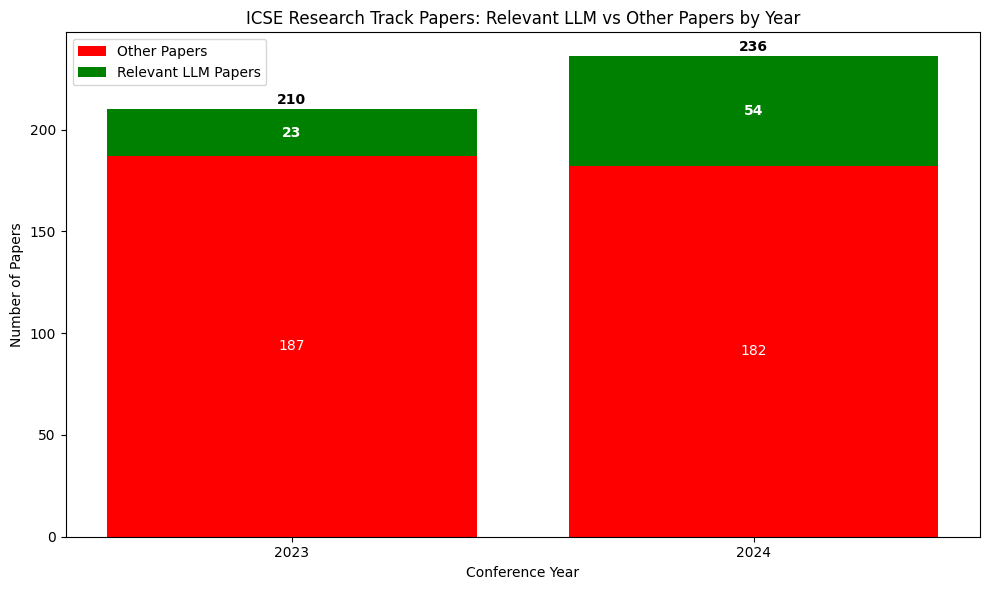

Summary Statistics:
----------------------------------------
ICSE 2023:
  Total papers: 210
  Relevant LLM papers: 23 (11.0%)
  Other papers: 187 (89.0%)

ICSE 2024:
  Total papers: 236
  Relevant LLM papers: 54 (22.9%)
  Other papers: 182 (77.1%)



In [33]:
def create_relevant_papers_comparison(df_23, df_24):
    """
    Create a stacked bar chart comparing relevant vs other papers by year.
    
    Parameters:
    - df_23: DataFrame for ICSE 2023 papers
    - df_24: DataFrame for ICSE 2024 papers
    """
    # Calculate counts for each year
    years = ['2023', '2024']
    dataframes = [df_23, df_24]
    
    relevant_counts = []
    non_relevant_counts = []
    total_counts = []
    
    for df in dataframes:
        total = len(df)
        relevant = df['relevant'].sum()
        non_relevant = total - relevant
        
        total_counts.append(total)
        relevant_counts.append(relevant)
        non_relevant_counts.append(non_relevant)
    
    plt.figure(figsize=(10, 6))
    
    plt.bar(years, non_relevant_counts, label='Other Papers', color='red')
    plt.bar(years, relevant_counts, bottom=non_relevant_counts, label='Relevant LLM Papers', color='green')
    
    plt.xlabel('Conference Year')
    plt.ylabel('Number of Papers')
    plt.title('ICSE Research Track Papers: Relevant LLM vs Other Papers by Year')
    plt.legend()
    
    for i, year in enumerate(years):
        plt.text(i, total_counts[i] + 1, str(total_counts[i]), 
                ha='center', va='bottom', fontweight='bold')
        
        if non_relevant_counts[i] > 0:
            plt.text(i, non_relevant_counts[i]/2, str(non_relevant_counts[i]), 
                    ha='center', va='center', color='white')
        
        if relevant_counts[i] > 0:
            plt.text(i, non_relevant_counts[i] + relevant_counts[i]/2, str(relevant_counts[i]), 
                    ha='center', va='center', color='white', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("Summary Statistics:")
    print("-" * 40)
    for i, year in enumerate(years):
        print(f"ICSE {year}:")
        print(f"  Total papers: {total_counts[i]}")
        print(f"  Relevant LLM papers: {relevant_counts[i]} ({relevant_counts[i]/total_counts[i]*100:.1f}%)")
        print(f"  Other papers: {non_relevant_counts[i]} ({non_relevant_counts[i]/total_counts[i]*100:.1f}%)")
        print()

create_relevant_papers_comparison(df_23, df_24)

# Word Cloud of AI Abstracts

In [ ]:
def create_wordcloud_with_ngrams(df, title="Word Cloud", use_bigrams=False):
    """
    Create a word cloud from abstracts using either unigrams OR bigrams.
    
    Parameters:
    - use_bigrams: If True, creates bigram word cloud. If False, creates unigram word cloud.
    """
    # Filter for AI papers
    # TODO: Update condition when relevant papers are selected
    relevant_papers = df[df["relevant"]]
    
    # Combine all abstracts into one text
    all_abstracts = " ".join(relevant_papers["abstract"].astype(str))
    
    # Get standard English stopwords
    sw = set(stopwords.words('english'))
    
    # Tokenize and clean (common for both branches)
    tokens = word_tokenize(all_abstracts.lower())
    clean_tokens = [token for token in tokens if token.isalpha() and len(token) > 2 and token not in sw]
    
    if use_bigrams:
        # Generate bigrams
        bigram_list = list(bigrams(clean_tokens))
        bigram_strings = [f"{word1}_{word2}" for word1, word2 in bigram_list]
        
        # Count bigram frequencies
        word_freq = Counter(bigram_strings)
        
        # Create text for word cloud
        wordcloud_text = []
        for bigram, freq in word_freq.items():
            wordcloud_text.extend([bigram] * freq)
        
        wordcloud_input = " ".join(wordcloud_text)
        
    else:
        # For unigrams - use clean tokens
        word_freq = Counter(clean_tokens)
        
        # Create text for word cloud
        wordcloud_text = []
        for word, freq in word_freq.items():
            wordcloud_text.extend([word] * freq)
        
        wordcloud_input = " ".join(wordcloud_text)
    
    # Generate word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        stopwords=set(),  # No additional stopwords needed since we pre-filtered
        max_words=100,
        relative_scaling=0.5,
        colormap='viridis',
        collocations=False
    ).generate(wordcloud_input)
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    # Print top terms
    gram_type = "bigrams" if use_bigrams else "unigrams"
    print(f"\nTop 20 most frequent {gram_type} in {len(relevant_papers)} LLM paper abstracts:")
    for term, count in word_freq.most_common(20):
        print(f"{term}: {count}")
    
    return word_freq

## Individual Years

### Unigram Word Clouds

ICSE 2023 Relevant LLM Papers Word Cloud (Unigrams):


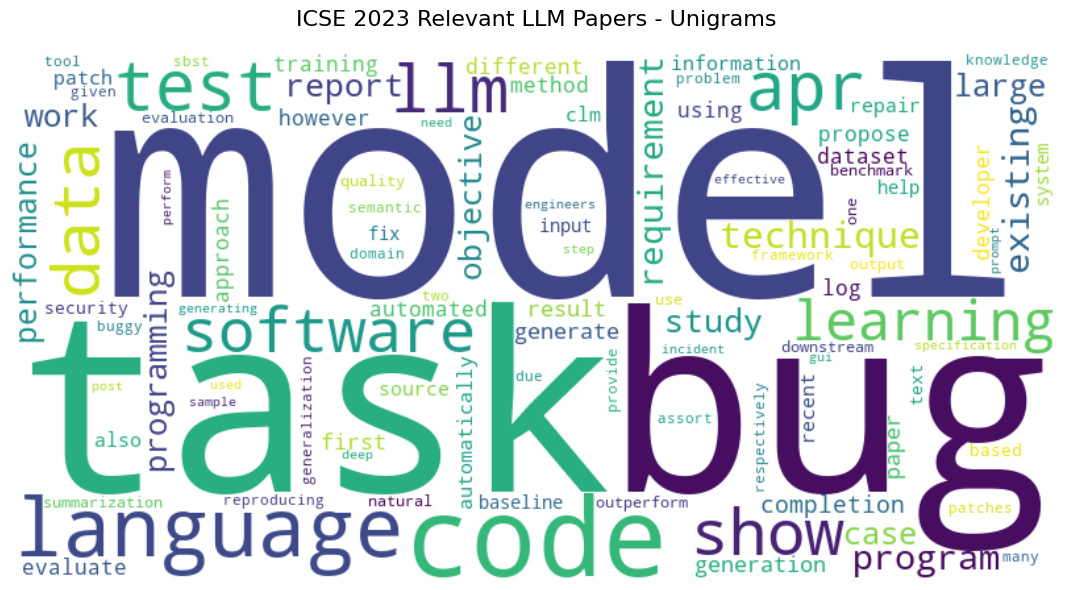


Top 20 most frequent unigrams in 23 LLM paper abstracts:
models: 42
code: 42
language: 30
bug: 28
model: 28
tasks: 24
apr: 24
data: 23
software: 20
learning: 20
existing: 19
task: 19
test: 19
llms: 18
requirements: 17
study: 16
techniques: 16
programming: 15
work: 15
large: 15


In [41]:
# Create unigram word clouds
print("ICSE 2023 Relevant LLM Papers Word Cloud (Unigrams):")
freq_2023_unigrams = create_wordcloud_with_ngrams(df_23, "ICSE 2023 Relevant LLM Papers - Unigrams", use_bigrams=False)

ICSE 2024 Relevant LLM Papers Word Cloud (Unigrams):


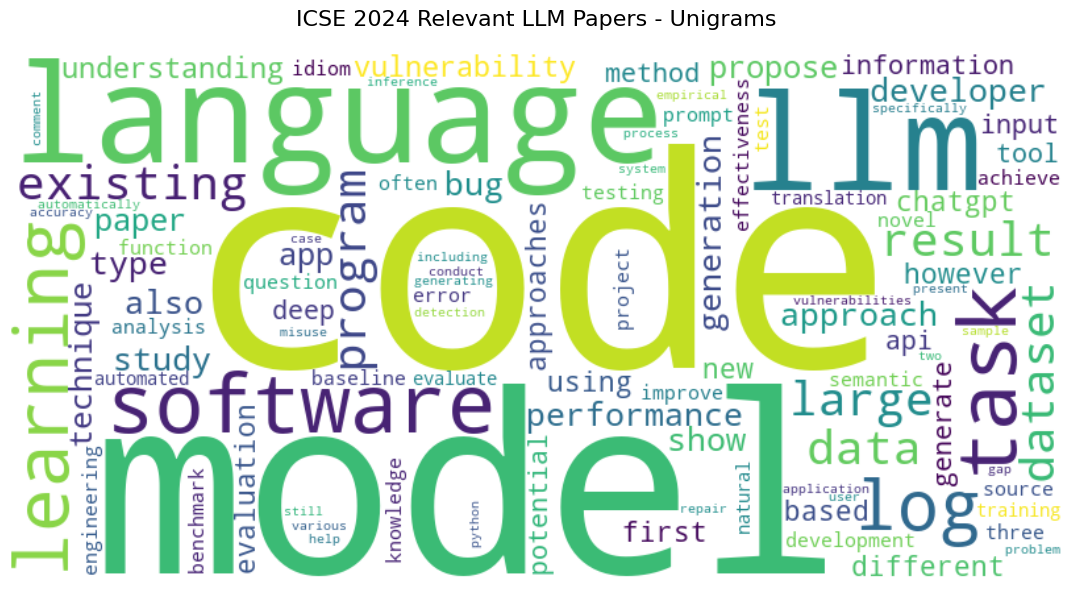


Top 20 most frequent unigrams in 54 LLM paper abstracts:
code: 212
models: 99
language: 82
llms: 62
software: 58
model: 48
learning: 47
tasks: 44
existing: 40
large: 39
results: 39
data: 39
performance: 35
study: 34
approach: 34
generation: 33
also: 32
developers: 32
log: 30
paper: 29


In [42]:
print("ICSE 2024 Relevant LLM Papers Word Cloud (Unigrams):")
freq_2024_unigrams = create_wordcloud_with_ngrams(df_24, "ICSE 2024 Relevant LLM Papers - Unigrams", use_bigrams=False)

### Bigram Word Clouds

ICSE 2023 Relevant LLM Papers Word Cloud (Bigrams):


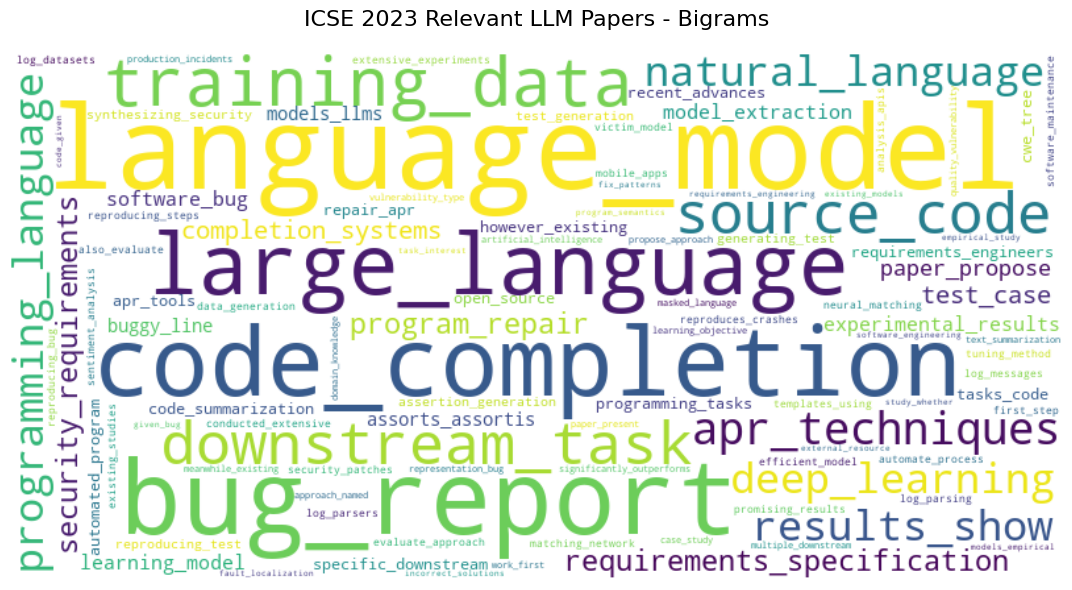


Top 20 most frequent bigrams in 23 LLM paper abstracts:
language_models: 17
code_completion: 14
bug_reports: 12
large_language: 11
training_data: 8
source_code: 8
apr_techniques: 7
results_show: 6
natural_language: 6
deep_learning: 6
program_repair: 6
security_requirements: 6
completion_systems: 6
paper_propose: 5
experimental_results: 5
model_extraction: 5
test_cases: 5
downstream_task: 4
downstream_tasks: 4
bug_report: 4


In [43]:
# Create bigram word clouds
print("ICSE 2023 Relevant LLM Papers Word Cloud (Bigrams):")
freq_2023_bigrams = create_wordcloud_with_ngrams(df_23, "ICSE 2023 Relevant LLM Papers - Bigrams", use_bigrams=True)

ICSE 2024 Relevant LLM Papers Word Cloud (Bigrams):


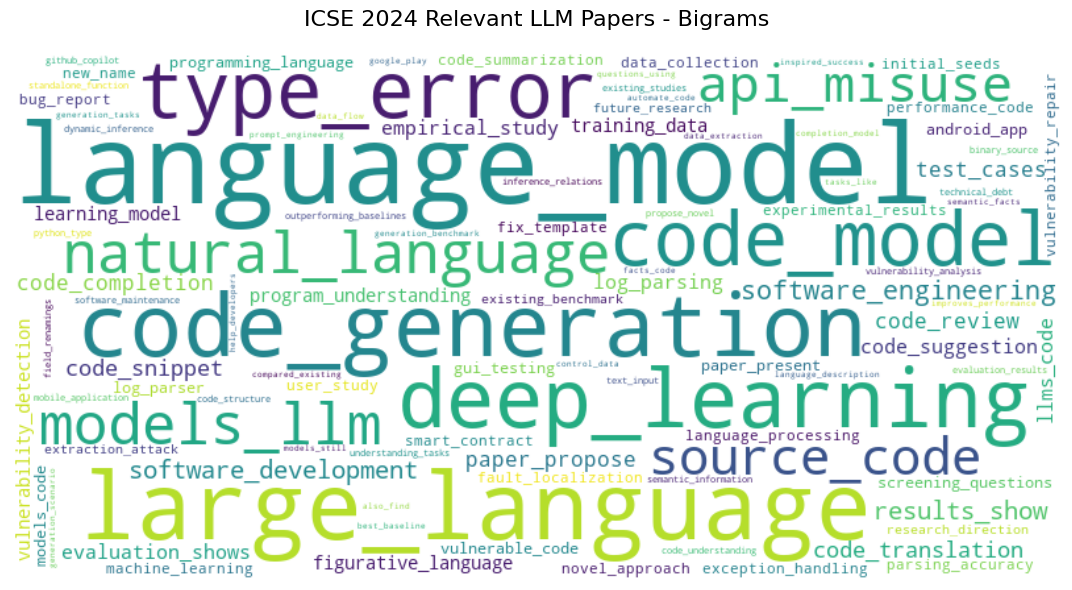


Top 20 most frequent bigrams in 54 LLM paper abstracts:
language_models: 34
large_language: 28
code_generation: 24
deep_learning: 21
natural_language: 17
models_llms: 16
type_errors: 15
source_code: 14
code_models: 14
software_engineering: 13
software_development: 12
results_show: 12
code_translation: 10
code_completion: 9
test_cases: 9
llms_code: 8
empirical_study: 8
log_parsing: 8
evaluation_shows: 8
api_misuse: 8


In [44]:
print("ICSE 2024 Relevant LLM Papers Word Cloud (Bigrams):")
freq_2024_bigrams = create_wordcloud_with_ngrams(df_24, "ICSE 2024 Relevant LLM Papers - Bigrams", use_bigrams=True)

## Combined Years

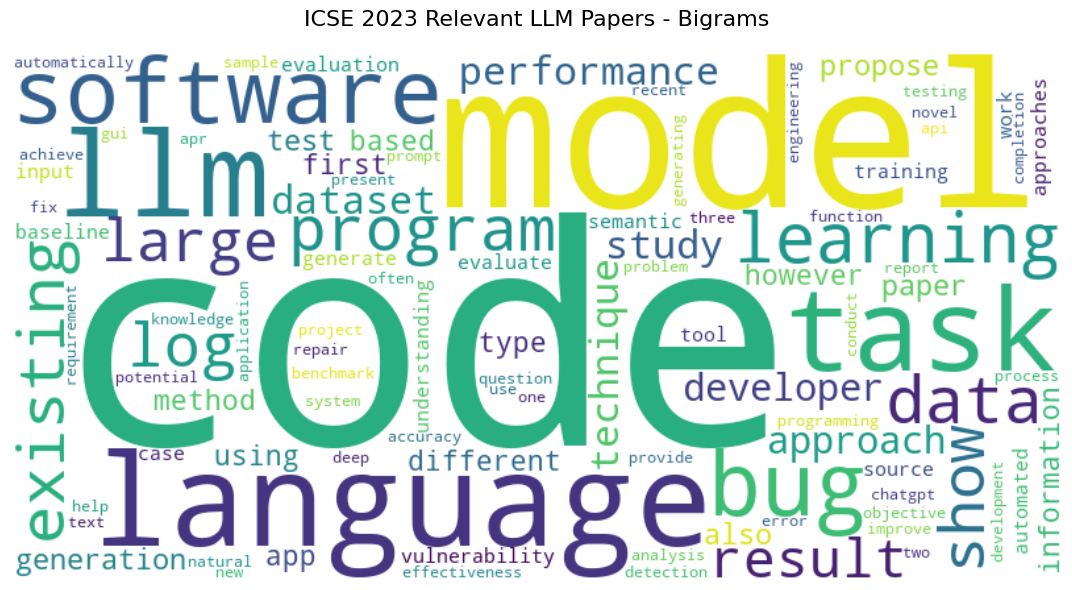


Top 20 most frequent unigrams in 77 LLM paper abstracts:
code: 254
models: 141
language: 112
llms: 80
software: 78
model: 76
tasks: 68
learning: 67
data: 62
existing: 59
large: 54
results: 51
study: 50
performance: 48
approach: 46
generation: 46
also: 43
paper: 42
bug: 42
log: 41


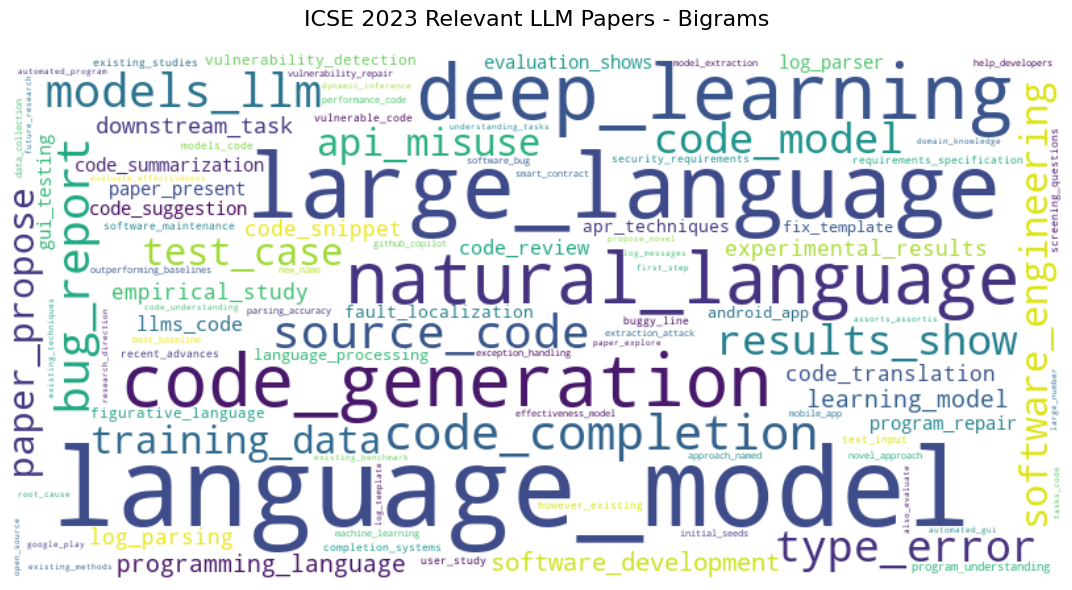


Top 20 most frequent bigrams in 77 LLM paper abstracts:
language_models: 51
large_language: 39
deep_learning: 27
code_generation: 24
natural_language: 23
code_completion: 23
source_code: 22
models_llms: 20
results_show: 18
bug_reports: 16
training_data: 15
software_engineering: 15
type_errors: 15
test_cases: 14
code_models: 14
software_development: 13
language_model: 11
log_parsing: 10
experimental_results: 10
empirical_study: 10


In [47]:
# Unigram Word Cloud
freq_combined_unigrams = create_wordcloud_with_ngrams(df_combined, "ICSE 2023 Relevant LLM Papers - Bigrams")

# Bigram Word Cloud
freq_combined_bigrams = create_wordcloud_with_ngrams(df_combined, "ICSE 2023 Relevant LLM Papers - Bigrams", use_bigrams=True)